In [8]:
import numpy as np
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.ellipsoid import Ellipsoid
from large_gcs.geometry.point import Point
from large_gcs.graph.graph import Graph, DefaultGraphCostsConstraints, Edge, Vertex
from pydrake.all import (RandomGenerator, Variables, MathematicalProgram,
                         DecomposeAffineExpression, DecomposeAffineExpressions,
                         HPolyhedron, VPolytope)
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [9]:
def scalar_proj_u_onto_v(u, v):
    u = np.array(u)
    v = np.array(v)
    return (np.dot(u,v)/np.linalg.norm(v))
def calc_rect_center_offset_from_halfspace(halfspace_normal, rect_lengths):
    """Returns the scalar offset in the normal direction that needs to be subtracted from the current offset such that the rect will not protrude from the original halfspace."""
    halfspace_normal = np.array(halfspace_normal)
    rect_lengths = np.array(rect_lengths)
    assert halfspace_normal.shape[0] == rect_lengths.shape[0]
    u = rect_lengths/2 * np.sign(halfspace_normal)
    return scalar_proj_u_onto_v(u, halfspace_normal)

In [10]:
S_coll_free_W= Polyhedron.from_vertices(([0,0],[10,-3],[13,5],[5,8]))
# S_coll_free_W.plot()

In [11]:
obj_lengths = [0.5, 3] # width, height
rob_radius = 1

def plot_square(center, radius):
    bottom_left = np.array(center) - radius
    width = 2*radius
    square = patches.Rectangle(bottom_left, width, width, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(square)

def plot_rectangle(center, width, height):
    bottom_left = np.array(center) - np.array([width/2, height/2])
    rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.scatter(center[0], center[1], c='r', s=3)

def plot_circle(center, radius):
    circle = patches.Circle(center, radius, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(circle)
    plt.scatter(center[0], center[1], c='r', s=3)

def offset_halfspace_eqns_by_rect(A, b, rect_lengths):
    A = np.array(A)
    b = np.array(b)
    rect_lengths = np.array(rect_lengths)
    
    assert A.shape[0] == b.shape[0]
    assert A.shape[1] == rect_lengths.shape[0]

    for i in range(A.shape[0]):
        offset = calc_rect_center_offset_from_halfspace(A[i], rect_lengths)
        b[i] -= offset
    return b

def offset_halfspace_eqns_by_sphere(b, radius):
    b = np.array(b)
    b -= radius
    return b


And now to double-check that the rectangles centered in the inner polyhedron don't exceed the outer polyhedron, we can use this function that randomly generates samples.

In [12]:
def get_samples_from_set(convex_set, n_samples=1000):
    samples = []
    generator = RandomGenerator(seed=1)
    samples.append(convex_set.set.UniformSample(generator))
    for i in range(n_samples-1):
        samples.append(convex_set.set.UniformSample(generator,previous_sample=samples[-1]))
    return samples

Now I'm going to try making the set in the higher dimensional configuration space for the robot being to the right of the object and in contact, and every other face not being in contact.

In [13]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(6,"x")
A = S_coll_free_W.set.A()
b = S_coll_free_W.set.b()
rob_b_offset = offset_halfspace_eqns_by_sphere(b, rob_radius)
rob_collision_free_exprs = A @ x[0:2,np.newaxis] - rob_b_offset[:,np.newaxis]

obj_b_offset = offset_halfspace_eqns_by_rect(A, b, obj_lengths)
obj_collision_free_exprs = A @ x[2:4,np.newaxis] - obj_b_offset[:,np.newaxis]

# Enforcing that the relative position of the robot and object
# aligns with the positions of the robot and object in the world frames
p_ObjRob_W = x[0:2] - x[2:4]
p_ObjRob_Obj = x[4:6]
# To get the equality, I need to do both p_ObjRob_W - p_ObjRob_Obj <= 0 and p_ObjRob_Obj - p_ObjRob_W <= 0
rob_obj_W_enforce_equality_exprs = np.hstack((p_ObjRob_W - p_ObjRob_Obj, p_ObjRob_Obj - p_ObjRob_W))[:,np.newaxis]

# robot is to the right of the object
# rob_radius + obj_lengths[0]/2 <= p_ObjRob_Obj
rob_obj_relative_exprs = np.array([rob_radius + obj_lengths[0]/2 - p_ObjRob_Obj[0]])[:,np.newaxis]

combined_exprs = np.vstack((rob_collision_free_exprs, obj_collision_free_exprs, rob_obj_W_enforce_equality_exprs, rob_obj_relative_exprs))
print(combined_exprs.shape)
print(combined_exprs)

A_higher_dim, b_higher_dim = DecomposeAffineExpressions(combined_exprs, x)
print(A_higher_dim.shape)
print(A_higher_dim)
print(b_higher_dim.shape)
print(b_higher_dim)

(13, 1)
[[<Expression "(0.99999999999997768 - 0.28734788556634538 * x(0) - 0.95782628522115132 * x(1))">]
 [<Expression "(-9.4166621004556443 + 0.93632917756904455 * x(0) - 0.3511234415883917 * x(1))">]
 [<Expression "(-8.2462506284943373 + 0.3511234415883917 * x(0) + 0.93632917756904455 * x(1))">]
 [<Expression "(0.99999999999997768 - 0.84799830400508802 * x(0) + 0.52999894000318004 * x(1))">]
 [<Expression "(1.5085763992232912 - 0.28734788556634538 * x(2) - 0.95782628522115132 * x(3))">]
 [<Expression "(-9.6558946436807958 + 0.93632917756904455 * x(2) - 0.3511234415883917 * x(3))">]
 [<Expression "(-7.7539760017436725 + 0.3511234415883917 * x(2) + 0.93632917756904455 * x(3))">]
 [<Expression "(1.0069979860060199 - 0.84799830400508802 * x(2) + 0.52999894000318004 * x(3))">]
 [<Expression "(x(0) - x(2) - x(4))">]
 [<Expression "(x(1) - x(3) - x(5))">]
 [<Expression "( - x(0) + x(2) + x(4))">]
 [<Expression "( - x(1) + x(3) + x(5))">]
 [<Expression "(1.25 - x(4))">]]
(13, 6)
[[-0.287347

## Solve a GCS problem with a single set that has no interior
Basically use GCS to sample a point within the set. Use the vanilla GCS machinery to just make sure this works.

In [25]:
from pydrake.all import (
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    Cost,
    Constraint,
    Binding,
    MathematicalProgramResult,
    Point,
    HPolyhedron,
    VPolytope
)
import numpy as np
from large_gcs.graph.cost_factory import create_l2norm_edge_cost


gcs = GraphOfConvexSets()
source_set = Point([0, 0])
target_set = Point([0, 9])
mid_set = HPolyhedron(VPolytope(np.array([[0.5,0.5],[1,0],[1,1]]).T))
gcs_edges = []
v_t = gcs.AddVertex(target_set, "t")
v_s = gcs.AddVertex(source_set, "s")
v_m = gcs.AddVertex(mid_set, "m")

edges = [(v_s, v_m), (v_m, v_t)]
cost = create_l2norm_edge_cost(2)
for edge in edges:
    e = gcs.AddEdge(edge[0], edge[1])
    gcs_edges.append(e)
    x = np.array([e.xu(), e.xv()]).flatten()
    binding = Binding[Cost](cost, x)
    e.AddCost(binding)

options = GraphOfConvexSetsOptions()
options.convex_relaxation = False

result = gcs.SolveShortestPath(
            v_s,
            v_t,
            options,
        )
assert result.is_success()
print(result.get_optimal_cost())
print(result.GetSolution(v_m.x()))

9.221799963073472
[0.5 0.5]


22.463563908057864
[3.07894748 2.45611145 1.82894745 1.0263159  1.25000003 1.42979555]


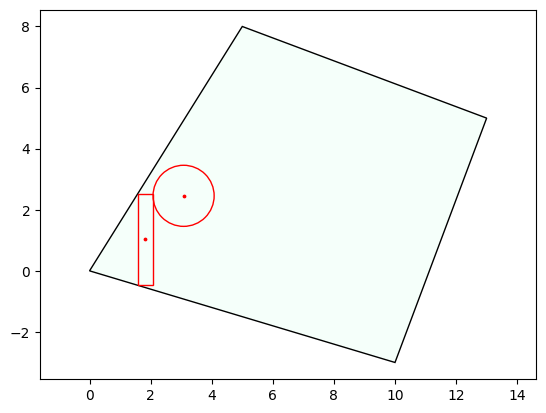

Equality constraint enforced: [ True  True]


In [29]:
from pydrake.all import (
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    Cost,
    Constraint,
    Binding,
    MathematicalProgramResult,
    Point,
    HPolyhedron,
    VPolytope
)
import numpy as np
from large_gcs.graph.cost_factory import create_l2norm_edge_cost

n_dim = A_higher_dim.shape[1]
gcs = GraphOfConvexSets()
source_set = Point([0] * n_dim)
target_set = Point([9] * n_dim)
mid_set = HPolyhedron(A_higher_dim, -b_higher_dim)
gcs_edges = []
v_t = gcs.AddVertex(target_set, "t")
v_s = gcs.AddVertex(source_set, "s")
v_m = gcs.AddVertex(mid_set, "m")

edges = [(v_s, v_m), (v_m, v_t)]
cost = create_l2norm_edge_cost(n_dim)
for edge in edges:
    e = gcs.AddEdge(edge[0], edge[1])
    gcs_edges.append(e)
    x = np.array([e.xu(), e.xv()]).flatten()
    binding = Binding[Cost](cost, x)
    e.AddCost(binding)

options = GraphOfConvexSetsOptions()
options.convex_relaxation = False

result = gcs.SolveShortestPath(
            v_s,
            v_t,
            options,
        )
assert result.is_success()
print(result.get_optimal_cost())
print(result.GetSolution(v_m.x()))
x_res = result.GetSolution(v_m.x())

S_coll_free_W.plot()
plot_circle(x_res[0:2], rob_radius)
plot_rectangle(x_res[2:4], *obj_lengths)
plt.show()
print(f"Equality constraint enforced: {x_res[0:2] - x_res[2:4] == x_res[4:6]}")

In [15]:
S_higher_dim = HPolyhedron(A_higher_dim, -b_higher_dim)

In [16]:
S_higher_dim.IsEmpty()

False

In [17]:
def get_samples_from_drake_set(set, n_samples=1000):
    samples = []
    generator = RandomGenerator(seed=1)
    samples.append(set.UniformSample(generator))
    for i in range(n_samples-1):
        samples.append(set.UniformSample(generator,previous_sample=samples[-1]))
    return samples

samples = get_samples_from_drake_set(S_higher_dim, n_samples=10)

ValueError: The Hit and Run algorithm failed to find a feasible point in the set. The `previous_sample` must be in the set.
max(A * previous_sample - b) = 1.2212453270876722e-15

In [14]:
S_higher_dim = Polyhedron(A_higher_dim, -b_higher_dim)

RuntimeError: QH6023 qhull input error: feasible point is not clearly inside halfspace
feasible point: 3.078947368421019 0.1203464403647248 1.82894736842102 1.026315789473672   1.25 -0.905969349108947 
     halfspace: -0.2873478855663454 -0.9578262852211513      0      0      0      0 
     at offset: 0.9999999999999777  and distance: 1.262878690511116e-15 
The halfspace was at index 0

While executing:  | qhull H
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 127805134  Halfspace  _maxoutside  0
